In [ ]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
from sklearn import linear_model, metrics
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from keras import datasets, layers, models


from keras.layers import Dense
from keras import datasets, layers, models
import math

from sklearn.cluster import KMeans
import tensorflow as tf
from keras import layers, datasets, models
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense



In [ ]:
df = pd.read_csv("/content/Train.csv")

In [ ]:
# df.dropna(subset=['PM2.5'], inplace=True)
features = ['PM2.5', 'TEMP', 'NO2', 'SO2', 'DEWP', 'O3', 'WSPM', 'RAIN']
df.dropna(subset=features, inplace=True)

In [ ]:
df.head()

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,1,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin
1,2,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin
2,3,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin
3,4,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Aotizhongxin
4,5,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0,Aotizhongxin


In [ ]:
# Assuming 'df' is your DataFrame containing the dataset
# Selecting the specified features: PM2.5, TEMP, NO2, SO2, DEWP, O3, WSPM, RAIN
# Adjust the column indices according to your DataFrame structure
features_columns = ['PM2.5', 'TEMP', 'NO2', 'SO2', 'DEWP', 'O3', 'WSPM', 'RAIN']  # Use the actual column names from your DataFrame

# Select all rows for these features
training_set = df[features_columns].values

# Check the length of the training_set
length_of_training_set = len(training_set)
print(length_of_training_set)


25977


In [ ]:
training_set = training_set[-5000:]

**Feature Scaling**

In [ ]:
# normalize your data for LSTM
sc = MinMaxScaler(feature_range = (0,1))
training_set_scaled = sc.fit_transform(training_set)

In [ ]:
lag = 48  # Number of hours to use as input to predict the next hour
n_obs = 5000  # Adjust this if needed based on your dataset size after preprocessing
features = 8  # Total number of features included

X_train = []
y_train = []

# Ensure you're selecting all features for X_train and only the PM2.5 values for y_train
for i in range(lag, n_obs):
    X_train.append(training_set_scaled[i-lag:i, :])  # Include all features in the lagged window
    y_train.append(training_set_scaled[i, 0])  # Assuming PM2.5 is the first feature for prediction

# Convert lists to numpy arrays for training the LSTM
X_train, y_train = np.array(X_train), np.array(y_train)

# Now, X_train should have the shape [samples, timesteps, features]
print(X_train.shape)  # Expected shape: (number of samples, lag, features)



(4952, 48, 8)


In [ ]:
X_train.shape

(4952, 48, 8)

# **LSTM**

without tuning hyperparameters

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam

model = Sequential()

# Adding the first LSTM layer with 200 units
model.add(LSTM(units=200, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(rate=0.1))  # Applying 10% dropout, adjusting according to your specification

# Adding a second LSTM layer with 100 units
model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(rate=0.1))  # Applying 10% dropout

# Adding the third LSTM layer with 50 units, return_sequences=True allows stacking another LSTM layer
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(rate=0.1))  # Applying 10% dropout

# Adding the last LSTM layer with 50 units
model.add(LSTM(units=50))  # This is the last LSTM layer, so return_sequences is not needed
model.add(Dropout(rate=0.1))  # Applying 10% dropout

# Adding the output layer
model.add(Dense(units=1))

In [ ]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 48, 200)           167200    
                                                                 
 dropout (Dropout)           (None, 48, 200)           0         
                                                                 
 lstm_1 (LSTM)               (None, 48, 100)           120400    
                                                                 
 dropout_1 (Dropout)         (None, 48, 100)           0         
                                                                 
 lstm_2 (LSTM)               (None, 48, 50)            30200     
                                                                 
 dropout_2 (Dropout)         (None, 48, 50)            0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                2

Fitting the LSTM to the Training set

In [ ]:
# Compiling the LSTM
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
# Fitting
model.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
155/155 [==============================] - 45s 236ms/step - loss: 0.0070
Epoch 2/50
155/155 [==============================] - 35s 226ms/step - loss: 0.0039
Epoch 3/50
155/155 [==============================] - 36s 234ms/step - loss: 0.0026
Epoch 4/50
155/155 [==============================] - 36s 232ms/step - loss: 0.0020
Epoch 5/50
155/155 [==============================] - 36s 235ms/step - loss: 0.0018
Epoch 6/50
155/155 [==============================] - 37s 235ms/step - loss: 0.0015
Epoch 7/50
155/155 [==============================] - 37s 236ms/step - loss: 0.0013
Epoch 8/50
155/155 [==============================] - 38s 245ms/step - loss: 0.0012
Epoch 9/50
155/155 [==============================] - 35s 229ms/step - loss: 0.0012
Epoch 10/50
155/155 [==============================] - 35s 224ms/step - loss: 0.0011
Epoch 11/50
155/155 [==============================] - 36s 232ms/step - loss: 0.0010
Epoch 12/50
155/155 [==============================] - 37s 237ms/step - lo

Making the predictions and visualising the results

In [ ]:
# Assuming 'sc' is your MinMaxScaler fitted on the training data
# And 'dataset_test' is your raw test dataset loaded from '/content/Test.csv'

# Load the test dataset (already done)
dataset_test = pd.read_csv('/content/Test.csv')

# Drop rows with NaN values in any of the columns you're using
dataset_test.dropna(subset=['PM2.5', 'TEMP', 'NO2', 'SO2', 'DEWP', 'O3', 'WSPM', 'RAIN'], inplace=True)

# Scale the test data using the same scaler as the training data
# Make sure to select the same features in the same order as the training set
test_features = dataset_test[['PM2.5', 'TEMP', 'NO2', 'SO2', 'DEWP', 'O3', 'WSPM', 'RAIN']].values
test_features_scaled = sc.transform(test_features)

# Prepare sequences for testing
X_test = []
for i in range(lag, len(test_features_scaled)):
    X_test.append(test_features_scaled[i-lag:i])  # Use all features

X_test = np.array(X_test)

# Reshape X_test if necessary (it might already be in the correct shape)
# X_test should now be shaped [samples, timesteps, features]
# No need to reshape based on the previous step since it already considers all features

# Make predictions
pred_PM2 = model.predict(X_test)

# Depending on your model's output, you might need to inverse scale the predictions
# If you scaled your target variable (PM2.5) during training


207/207 [==============================] - 16s 71ms/step


In [ ]:
pred_PM2 = model.predict(X_test)
pred_PM2

207/207 [==============================] - 15s 71ms/step


array([[0.06090742],
       [0.05947828],
       [0.05736827],
       ...,
       [0.02562559],
       [0.03567392],
       [0.03856816]], dtype=float32)

In [ ]:
# Assume pred_PM2 is your predictions with shape (num_samples, 1)
# Create an array with the same number of columns as the original scaled data
pred_full = np.zeros((pred_PM2.shape[0], 8))  # 8 for the number of features you have

# Assuming PM2.5 is the first column, fill in your predictions there
pred_full[:, 0] = pred_PM2.ravel()  # Use ravel() to ensure it's a 1D array

# Perform the inverse transformation
pred_full_inverse = sc.inverse_transform(pred_full)

# Extract the PM2.5 predictions after inverse transforming
pred_PM2_inverse = pred_full_inverse[:, 0]



In [ ]:
# Assuming dataset_test is your test DataFrame and it's already preprocessed to drop NaNs as before
real_PM2 = dataset_test['PM2.5'].values[-len(pred_PM2):]  # Make sure to align the lengths

# Ensure real_PM2 is properly shaped for comparison
# If necessary, reshape it (though it should already be a 1D array matching pred_PM2_inverse in length)
real_PM2 = real_PM2.reshape(-1, 1)  # Only needed if real_PM2 isn't already a 1D array

# Now proceed with RMSE calculation
RMSE = np.sqrt(np.mean((pred_PM2_inverse - real_PM2.ravel())**2))  # Use ravel() to ensure it's 1D for calculation
print("RMSE:", RMSE)


RMSE: 21.64377177891973


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(real_PM2, pred_PM2_inverse))

# Calculate MAE
mae = mean_absolute_error(real_PM2, pred_PM2_inverse)

# Calculate MSE
mse = mean_squared_error(real_PM2, pred_PM2_inverse)

# Calculate MAPE - Note: You have to ensure real_PM2 does not contain zeros to avoid division by zero
mape = np.mean(np.abs((real_PM2 - pred_PM2_inverse) / real_PM2)) * 100

# Calculate R-squared
r2 = r2_score(real_PM2, pred_PM2_inverse)

# Print the results
print('RMSE: {:.4f}'.format(rmse))
print('MAE: {:.4f}'.format(mae))
print('MSE: {:.4f}'.format(mse))
print('MAPE: {:.4f}%'.format(mape))
print('R-squared: {:.4f}'.format(r2))

RMSE: 21.6438
MAE: 14.3116
MSE: 468.4529
MAPE: 306.0166%
R-squared: 0.9349


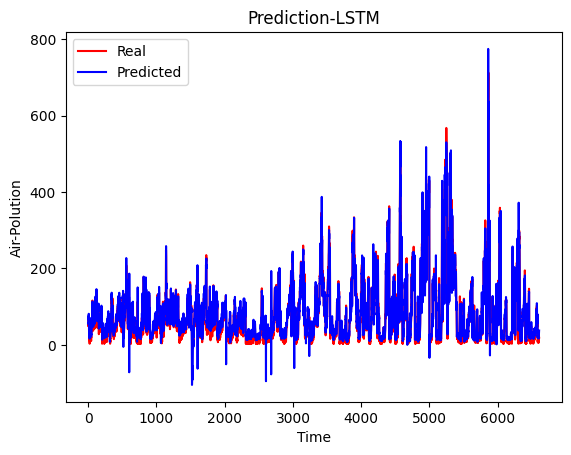

In [ ]:
plt.plot(real_PM2, color = 'red', label = 'Real')
plt.plot(pred_PM2_inverse, color = 'blue', label = 'Predicted')
plt.title('Prediction-LSTM')
plt.xlabel('Time')
plt.ylabel('Air-Polution')
plt.legend()
plt.show()

with tuning hyperparameters

In [ ]:
pip install keras-tuner


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.3 MB/s eta 0:00:00


In [ ]:
from keras_tuner import RandomSearch, HyperParameters



In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from keras_tuner import RandomSearch, HyperParameters

def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units1', min_value=100, max_value=200, step=100),
                   return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(rate=hp.Float('dropout1', min_value=0.1, max_value=0.3, step=0.2)))
    model.add(LSTM(units=hp.Int('units2', min_value=100, max_value=200, step=100), return_sequences=True))
    model.add(Dropout(rate=hp.Float('dropout2', min_value=0.1, max_value=0.3, step=0.2)))
    model.add(LSTM(units=hp.Int('units3', min_value=100, max_value=200, step=100)))
    model.add(Dropout(rate=hp.Float('dropout3', min_value=0.1, max_value=0.3, step=0.2)))
    model.add(Dense(units=1))
    model.compile(optimizer=Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
                  loss='mean_squared_error')
    return model




In [ ]:
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=3,
    directory='tuner_results',
    project_name='lstm_tuning'
)

# Use a portion of training data for validation since a separate validation set is not available
tuner.search(X_train, y_train, epochs=20, validation_split=0.2)



Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
100               |100               |units1
0.1               |0.1               |dropout1
100               |100               |units2
0.1               |0.1               |dropout2
100               |100               |units3
0.1               |0.1               |dropout3
0.0002833         |0.0002833         |learning_rate

Epoch 1/20
124/124 [==============================] - 31s 140ms/step - loss: 0.0067 - val_loss: 0.0045
Epoch 2/20
124/124 [==============================] - 16s 130ms/step - loss: 0.0050 - val_loss: 0.0021
Epoch 3/20
124/124 [==============================] - 18s 144ms/step - loss: 0.0039 - val_loss: 0.0017
Epoch 4/20
124/124 [==============================] - 16s 131ms/step - loss: 0.0033 - val_loss: 0.0019
Epoch 5/20
124/124 [==============================] - 16s 131ms/step - loss: 0.0029 - val_loss: 0.0021
Epoch 6/20
124/124 [==============================] - 19s 153ms/step - loss:

KeyboardInterrupt: 

In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]
test_loss = best_model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")


In [ ]:
# Assuming best_model is the best model obtained from the tuner
predictions = best_model.predict(X_test)


In [ ]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error on test data: {mse}")


In [ ]:
# Assuming 'scaler' is your MinMaxScaler instance and 'y_test' was scaled
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))
predictions_inverse = scaler.inverse_transform(predictions)

# Then calculate MSE on the inverse-transformed values
mse_inverse = mean_squared_error(y_test_inverse, predictions_inverse)
print(f"Mean Squared Error on test data (original scale): {mse_inverse}")


In [ ]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print('Best hyperparameters found were:')
print(f"Units in the first LSTM layer: {best_hps.get('units1')}")
print(f"Dropout rate in the first LSTM layer: {best_hps.get('dropout1')}")
print(f"Units in the second LSTM layer: {best_hps.get('units2')}")
print(f"Dropout rate in the second LSTM layer: {best_hps.get('dropout2')}")
print(f"Units in the third LSTM layer: {best_hps.get('units3')}")
print(f"Dropout rate in the third LSTM layer: {best_hps.get('dropout3')}")
print(f"Learning rate for the optimizer: {best_hps.get('learning_rate')}")

